In [1]:
%load_ext autoreload
%autoreload 2
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()


In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg.set_sys_path()
from pylib import *
pkg

`isr.umich.edu-psid-inequality-3.2.1` Last Update: 2023-06-16T00:20:09

__



## Updating Data

To update the data, use the data extraction tool at the (PSID website. )[https://simba.isr.umich.edu/Cart/co.aspx], adding any new variables to your data cart. The (variable entry text box)[https://simba.isr.umich.edu/DC/l.aspx] is a handy way to copy the existing varibles into a new cart.  When you checkout your data cart, ( click on the cart icon ) fetch your dataset with these options: 

* Codebook Type: XML
* Data output type: dBase Data File, create compressed file

Download the ZIP file ( you might have to recompress it if your browser unpacks it ) and move it into the ``data`` directory. Set the reference to the new ZIP file, then re-build the package.
## Documentation Links

* [PSID Homepage](https://psidonline.isr.umich.edu/default.aspx) 

 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* **[variables](data/variables.csv)**. All PSID variables, with group infor for connecting variables across years.
* **[cmp9919_labels](data/cmp9919_labels.csv)**. Categorical value labels
* **[long_wealth_labels](data/long_wealth_labels.csv)**. Categorical value labels
* **[cmp9919_dd](data/cmp9919_dd.csv)**. Data dictionary with information about variables in this collection, extracted from XML
* **[long_wealth_dd](data/long_wealth_dd.csv)**. Data dictionary with information about variables in this collection, extracted from XML
* **[cmp9919](data/cmp9919.csv)**. PSID, Inequality extract
* **[long_wealth](data/long_wealth.csv)**. Longitudinal Wealth

## References
<ul><li> <strong><a href="https://fred.stlouisfed.org/graph/fredgraph.csv?&id=CPIAUCSL">cpi</a></strong>. Consumer Price Index, from FRED series CPIAUCSL</li><li> <strong><a href="https://psidonline.isr.umich.edu/help/xyr/psid.xlsx">variables</a></strong>. Variable descriptions, in a cross-year format.</li><li> <strong>cmp9919_source</string>, <em>data/J321148.zip</em>. Source file for comparing 1999 to 2019</li><li> <strong>long_wealth_source</string>, <em>data/J321388.zip</em>. Source data package for Longitudinal Wealth Study</li><ul>

In [3]:
r = pkg.resource('long_wealth')
df = pkg.resource('long_wealth').dataframe()
df.head()

,pid,year,race,er30001,er30002,er30000,er33501,er33503,er13001,er33502,...,er16462,er16518,s405,s419,s420,s415,s411,s413,s417,s416
0,4001,2001,NaN,4,1,3,0,0,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4003,2001,1.0,4,3,3,96,10,6.0,1,...,50880.0,19.812,50.0,0.0,90000.0,0.0,15000.0,8000.0,113050.0,23050.0
2,4004,2001,1.0,4,4,3,5987,10,6.0,1,...,50000.0,30.397,10000.0,35000.0,68000.0,0.0,10000.0,20000.0,493000.0,425000.0
3,4006,2001,1.0,4,6,3,5599,22,6.0,2,...,92000.0,19.566,4000.0,0.0,13000.0,0.0,0.0,6000.0,23000.0,10000.0
4,4007,2001,1.0,4,7,3,7091,10,6.0,1,...,55616.0,24.971,15000.0,0.0,17000.0,0.0,0.0,9000.0,41000.0,24000.0


In [4]:
m = Metadata(r)
m.lookup('ER33616').T

,241
type,INDIVIDUAL
category,EDUCATION
text,01>EDUCATION:\n02>Completed Education\n03>grad...
head_wife,NaN
var_count,40
group,64
year,2001
name,ER33616
path,/education:/completed education/grades completed:


In [27]:
r = pkg.resource('long_wealth')
cat = r.cat

# These have missing/imputed values that make them categories, but they really should be numeric
non_cats = ['ER16515B3', 'ER16515B2', 'ER16515B5', 'ER16515B4',
            'S405', 'S419', 'S420', 'S415', 'S411', 'S413', 'S417', 'S416' ]

non_cats = [c.lower() for c in non_cats]

for c in non_cats:
    try:
        cat.remove(c)
    except KeyError:
        print("Can't remove ", c, " from cat")

    if not c.startswith('S'):
        df[c] = df[c].replace( { 9999999.0: np.nan } )

df['married'] = (df.er33507 != 0)


dfc = cat.to_categorical(df)


In [28]:
# Calculate the sum of all expenditures

# Exclude some to avoid double counts.
excludes = ['er16515a2', 'er16515a3', 'er16515a4', # components of food
            'er16515a6' # mortgage, component of housing

            ]

exp_cols = [c['name'] for c in r.columns() if c['category'] == 'EXPENDITURES' and c['name'] not in excludes ]
dfc['exp'] = dfc[exp_cols].sum(axis=1) # df categorized



In [35]:
col_map = {

    'er30001':'1968_interview_number',
    'er30002':'person_number',
    'er30000':'release_number',

    'er13001': 'release_number',
    'er13009': 'num_in_fu',
    'er13010': 'age_of_head',
    'er13011': 'sex_of_head',
    'er13012': 'age_of_wife',
    'er13013': 'num_children_in_fu',
    'er13041': 'house_value',
    'er15928': 'race_of_head_1',
    'er15929': 'race_of_head_2',
    'er15930': 'race_of_head_3',
    'er15931': 'race_of_head_4',
    'er16462': 'total_family_income',

    's420': 'home_equity',
    's416': 'wealth_wo_equity',
    's417': 'wealth_w_equity',
    'er33501': 'interview_number',
    'er33502': 'sequence_number',
    'er33503': 'relation_to_head',
    'er33507': 'marital_pairs_indicator',
    'er33516': 'years_completed_education',

    'er16519': 'family_weight_cs', # Cross-sectional family weight
    'er16518':'family_weight',

    'er15836':'k34_87_race_of_wife_1',
    'er15837':'k34_87_race_of_wife_2',
    'er15838':'k34_87_race_of_wife_3',
    'er15839':'k34_87_race_of_wife_4',

    'er16515a1': 'food_expenditure',
    'er16515a2': 'food_at_home_expenditure',
    'er16515a3': 'food_away_from_home_expenditure',
    'er16515a4': 'food_delivered_expenditure',
    'er16515a5': 'housing_expenditure',
    'er16515a6': 'mortgage_expenditure',
    'er16515b6': 'transportation_expenditure',
    'er16515b7': 'vehicle_loan_payment_expenditure',
    'er16515b9': 'vehicle_lease_payment_expenditure',
    'er16515c9': 'education_expenditure',
    'er16515d1': 'childcare_expenditure',
    'er16515c2':'additional_vehicle_expenditure',
    'er16515c1':'auto_insurance_expenditure',
    'er16515c6':'bus_train_expenditure',
    'er16515d4':'doctor_expenditure_1998',
    'er16515b3':'electricity_expenditure',
    'er16515b2':'gas_for_home_expenditure',
    'er16515c4':'gasoline_expenditure',
    'er16515d2':'health_care_expenditure',
    'er16515d6':'health_insurance_expenditure',
    'er16515a9':'home_insurance_expenditure',
    'er16515d3':'hospital_nursing_home_expenditure_1998',
    'er16515c8':'other_transportation_expenditure',
    'er16515b5':'other_utility__expenditure',
    'er16515c5':'parking_expenditure',
    'er16515d5':'prescriptions_other_expenditure_1998',
    'er16515a8':'property_tax_expenditure',
    'er16515a7':'rent_expenditure',
    'er16515c7':'taxicab_expenditure',
    'er16515b1':'utility_expenditure',
    'er16515b8':'vehicle_down_payment_expenditure',
    'er16515c3':'vehicle_repair_expenditure',
    'er16515b4':'water_sewer_expenditure'

}

cmap = { c['name']:c for c in r.columns() }

for c in dfc.rename(columns=col_map).columns:
    if  c.startswith('er'):
        print(f"'{c}':'{cmap[c]['label'].replace('/','_').replace(' ','_').replace('_1999','').lower()}',")

dfm = dfc.rename(columns=col_map) # df mapped

In [36]:
cats = dfm.relation_to_head.cat.categories.to_list()
cats[0] = 'na'
cats[1] = 'head'
cats[2] = 'wife'
cats[3] = 'chwife'
cats[4] = 'child_of_head'

dfm['relation_to_head'] = dfm.relation_to_head.cat.rename_categories(cats)

dfm['nonmort_housing_expenditure'] = dfm.housing_expenditure - dfm.mortgage_expenditure



In [37]:
# Remove the records with an inconsistent head of family and fewer than 9 income observations

t = dfm[(dfm.relation_to_head == 'head')].dropna(subset=['total_family_income','race'])
t = t.groupby('pid').total_family_income.count()
valid_pids = t[t==10].index.to_list() # For now, us 10 so we don't have to interpolate

dfh = dfm[(dfm.pid.isin(valid_pids))]

dfh.shape

(31510, 71)

In [38]:
# Add in CPI to adjust for inflation
cpi = pkg.reference('cpi').dataframe()
cpi.columns = ['date','cpi']
cpi['date'] = pd.to_datetime(cpi.date)
cpi.date = pd.to_datetime(cpi.date)
cpi = cpi.groupby(cpi.date.dt.year).mean(numeric_only=True).reset_index().rename(columns={'date':'year'})

cpi = cpi[cpi.year <= dfh.year.max()] # So cpi.max() uses the last year of the dataset

cpi['cpi_current'] = cpi.cpi.max()/cpi.cpi

dfh = dfh.merge(cpi,how='left',on='year')

In [207]:
dfe  = dfh[['pid','year','race','age_of_head', 'num_children_in_fu', 'married',
            'total_family_income','exp','home_equity','wealth_w_equity','wealth_wo_equity',
            'housing_expenditure', 'nonmort_housing_expenditure', 'mortgage_expenditure',
            'cpi_current','family_weight'
            ]].copy().sort_values(['pid','year'])

dfe['race'] = dfe.race.astype(str) # So we can drop all by black/white, and the other groups wont show ur after groupby


In [208]:
cpi_cols = ['total_family_income','exp','home_equity','wealth_w_equity',  'wealth_wo_equity',
            'nonmort_housing_expenditure', 'mortgage_expenditure']

dfe[cpi_cols] = dfe[cpi_cols].multiply(dfe.cpi_current,axis=0).astype(int).copy()

dfe = dfe[dfe.race.isin(['white','black'])]

In [210]:
dfe.groupby(['race','married']).median().T

race                             black                 white           
married                          False      True       False      True 
pid                          5683003.0  5635031.0  1577031.0  1579031.0
year                            2011.0     2009.0     2011.0     2009.0
age_of_head                       49.0       50.0       54.0       52.0
num_children_in_fu                 0.0        1.0        0.0        0.0
total_family_income            29591.0    77677.0    43641.0   102239.0
exp                            38892.0    72430.0    43181.0    82934.5
home_equity                        0.0    32923.0     6472.0   104739.0
wealth_w_equity                 5545.0    64142.0    49207.5   232998.5
wealth_wo_equity                1444.0    17259.0    16582.5    87795.0
housing_expenditure             9036.0    15383.0     9420.0    18060.0
nonmort_housing_expenditure     9206.0    12206.0     8838.5    12616.0
mortgage_expenditure               0.0     5200.0        0.0     7767.0
cpi_current                   1.136619    1.19149   1.136619    1.19149
family_weight                    6.339       3.89     49.567    27.1765

In [252]:
# Columns where we will compute a difference between the first and last year
diff_cols = ['home_equity','wealth_w_equity',  'wealth_wo_equity']

# Columns where we will sum the values
sum_cols = ['total_family_income','exp','housing_expenditure', 'nonmort_housing_expenditure', 'mortgage_expenditure']

def compile(x):
    return pd.concat([
        pd.Series({'age':x.age_of_head.mean(),
                   'race': x.race.mode()[0],
                   'years_married':x.married.sum(), # Number of years married
                   'num_children':x.num_children_in_fu.mean()}),

        x[sum_cols].sum() * 2, # x2 because we only have samples for 1/2 of the years
        (x[diff_cols].iloc[-1] - x[diff_cols].iloc[0])

    ])

sumry = dfe[dfe.race.isin(['black','white'])].groupby('pid').apply(compile)

In [253]:
sumry['income_q'] = pd.qcut(sumry.total_family_income, 10, labels=False, duplicates='drop')
sumry['home_eq_q'] = pd.qcut(sumry.home_equity, 10, labels=False, duplicates='drop')
sumry['wealth_w_equity_q'] = pd.qcut(sumry.wealth_w_equity, 10, labels=False, duplicates='drop')

sumry['married'] = sumry.years_married.apply(lambda x: 'none' if x == 0 else  'all' if x == 10 else 'some')


In [260]:
dfe.sample(10)

,pid,year,race,age_of_head,num_children_in_fu,married,total_family_income,exp,home_equity,wealth_w_equity,wealth_wo_equity,housing_expenditure,nonmort_housing_expenditure,mortgage_expenditure,cpi_current,family_weight
10942,2138003,2007,white,55.0,0.0,True,206154,101501,305779,478397,172617,36580.0,19333,25769,1.232982,29.377
31215,6156181,2019,white,56.0,0.0,False,14109,25520,0,-14997,-14997,10248.0,10248,0,1.000000,0.245
14750,3156001,2009,white,41.0,2.0,True,124510,149858,212085,317889,105804,48394.0,12474,45186,1.191490,26.591
17054,1878170,2011,white,67.0,0.0,True,70697,62861,79563,536938,457375,20230.0,6285,16708,1.136619,41.371
20055,1682032,2013,white,44.0,2.0,True,172320,140648,76821,87795,10974,50980.0,35315,20631,1.097445,10.342
2798,5995005,2001,black,36.0,2.0,False,25767,37761,0,3898,3898,6000.0,8664,0,1.444020,4.707
7753,2075032,2005,black,25.0,0.0,False,19998,34465,0,-26184,-26184,9485.0,12418,0,1.309244,0.852
21792,6200170,2013,black,60.0,0.0,True,158471,89090,274361,317161,42800,21000.0,23046,0,1.097445,1.538
27268,2893173,2017,white,68.0,0.0,True,75823,102877,417184,12137981,11720796,34280.0,35752,0,1.042961,31.319
21942,6605012,2013,black,52.0,0.0,False,2524,1079,0,0,0,192.0,210,0,1.097445,3.017


In [261]:
x = dfe[dfe.pid == 1682032]
(x[diff_cols].iloc[-1] - x[diff_cols].iloc[0])
x

,pid,year,race,age_of_head,num_children_in_fu,married,total_family_income,exp,home_equity,wealth_w_equity,wealth_wo_equity,housing_expenditure,nonmort_housing_expenditure,mortgage_expenditure,cpi_current,family_weight
1149,1682032,2001,white,32.0,0.0,False,60648,53729,0,-18772,-18772,8280.0,11956,0,1.444020,16.465
4300,1682032,2003,white,34.0,0.0,True,146860,101592,52797,13894,-38903,17028.0,9281,14377,1.389411,8.650
7451,1682032,2005,white,36.0,1.0,True,148625,136008,85100,79863,-5236,36660.0,24168,23828,1.309244,8.649
10602,1682032,2007,white,38.0,2.0,True,155392,154053,220703,223169,2465,33650.0,17323,24166,1.232982,9.377
13753,1682032,2009,white,40.0,2.0,True,166839,151867,178723,225191,46468,34920.0,23496,18110,1.191490,9.377
16904,1682032,2011,white,42.0,2.0,True,167787,143032,39781,150033,110252,38290.0,23800,19720,1.136619,10.342
20055,1682032,2013,white,44.0,2.0,True,172320,140648,76821,87795,10974,50980.0,35315,20631,1.097445,10.342
23206,1682032,2015,white,46.0,2.0,True,168869,145579,107869,118656,10786,56730.0,39943,21250,1.078691,11.870
26357,1682032,2017,white,48.0,2.0,True,187785,133060,125155,154358,29202,44100.0,25969,20024,1.042961,11.870
29508,1682032,2019,white,50.0,2.0,True,195026,168820,195000,246000,51000,53170.0,33570,19600,1.000000,13.351


In [254]:
t = sumry[sumry.age.between(45,55) & sumry.income_q.isin([4,5,6])]

t.groupby(['married', 'race']).wealth_w_equity.mean().unstack()

race,black,white
married,,
all,33420.346154,157223.594059
none,-251320.526316,233005.190476
some,58321.120000,65808.926829


<AxesSubplot: xlabel='wealth_w_equity_q', ylabel='Density'>

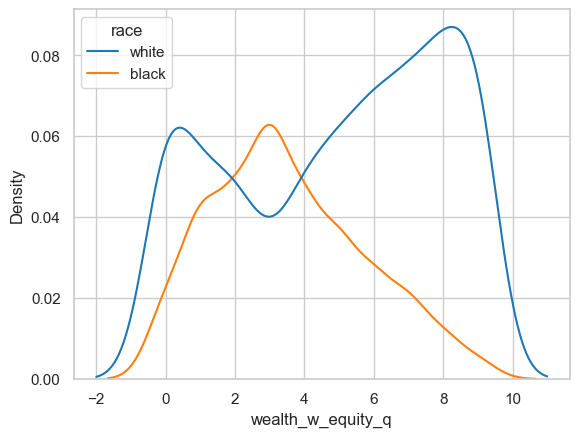

In [191]:
t =sumry[['race','income_q']].value_counts().reset_index().rename(columns={0:'count'})
t.sort_values(['income_q', 'race'])

# Plot a histogram of t, seperates in hue on race
import seaborn as sns
sns.kdeplot(data=sumry, x='wealth_w_equity_q',hue='race')


In [223]:
sumry[sumry.married==False][['income_q','home_eq_q','wealth_w_equity_q', 'wealth_wo_equity']].corr()

,income_q,home_eq_q,wealth_w_equity_q,wealth_wo_equity
income_q,1.000000,0.314498,0.293691,0.079595
home_eq_q,0.314498,1.000000,0.670331,0.127242
wealth_w_equity_q,0.293691,0.670331,1.000000,0.454931
wealth_wo_equity,0.079595,0.127242,0.454931,1.000000


In [157]:
z = sumry.corr(numeric_only=True).stack().reset_index().sort_values(0, ascending=False)
z[z[0]!=1].head(10)

,level_0,level_1,0
119,wealth_wo_equity,wealth_w_equity,0.977504
109,wealth_w_equity,wealth_wo_equity,0.977504
59,housing_expenditure,exp,0.870981
49,exp,housing_expenditure,0.870981
62,housing_expenditure,mortgage_expenditure,0.841173
82,mortgage_expenditure,housing_expenditure,0.841173
71,nonmort_housing_expenditure,housing_expenditure,0.840668
61,housing_expenditure,nonmort_housing_expenditure,0.840668
47,exp,total_family_income,0.776554
37,total_family_income,exp,0.776554


In [158]:
t.corrwith(t.wealth_w_equity, numeric_only=True).sort_values(ascending=False)

wealth_w_equity                1.000000
wealth_wo_equity               0.976539
total_family_income            0.462240
home_equity                    0.356173
exp                            0.321057
housing_expenditure            0.283785
nonmort_housing_expenditure    0.248196
mortgage_expenditure           0.226978
num_children                  -0.005011
age                           -0.037886
dtype: float64

In [172]:
a,b = sumry.total_family_income.quantile([.4,.6])
print(a,b)
sumry_46 = sumry[(sumry.total_family_income >= a) & (sumry.total_family_income <= b) ].copy()
print(len(sumry), len(sumry_46))
sumry_46.groupby('race').home_equity.count()

1208384.4000000001 1829699.2
2994 328


race
black     82
white    246
Name: home_equity, dtype: int64

In [167]:
sumry_46['wir'] = sumry.wealth_w_equity/sumry.total_family_income
sumry_46['eir'] = sumry.exp/sumry.total_family_income

In [168]:
z = sumry_46.groupby('race').mean()
z['sav'] = z.total_family_income - z.exp
z

,age,married,num_children,total_family_income,exp,housing_expenditure,nonmort_housing_expenditure,mortgage_expenditure,home_equity,wealth_w_equity,wealth_wo_equity,wir,eir,sav
race,,,,,,,,,,,,,,
black,51.447561,1.0,0.974390,1.489100e+06,1.502715e+06,327173.007073,255061.853659,127830.878049,36674.804878,-27392.109756,-64066.743902,-0.022903,1.014159,-13615.048780
white,52.273171,1.0,0.836179,1.535392e+06,1.459032e+06,314950.553333,245039.357724,121871.764228,46827.227642,69206.280488,22379.410569,0.047229,0.957359,76359.430894


In [170]:
z.iloc[1]-z.iloc[0]

age                                0.825610
married                            0.000000
num_children                      -0.138211
total_family_income            46292.065041
exp                           -43682.414634
housing_expenditure           -12222.453740
nonmort_housing_expenditure   -10022.495935
mortgage_expenditure           -5959.113821
home_equity                    10152.422764
wealth_w_equity                96598.390244
wealth_wo_equity               86446.154472
wir                                0.070132
eir                               -0.056800
sav                            89974.479675
dtype: float64